# Аналитика в Яндекс Афише

В данном проекте анализируются бизнес-метрики (DAU,MAU,WAU,Retention Rate, ARPU, LTV, CAC, ROI) для того, чтобы выявить наиболее эффективный канал привлечения пользователей. 

<a id="0"></a>
## Оглавление

1. [Загрузка данных](#1)
2. [Отчеты и метрики](#2)<br>
**2.1 [Продукт](#2.1)<br>**
2.1.1 [Сколько людей пользуются в день, неделю, месяц?](#2.1.1)<br>
2.1.2 [Сколько сессий в день?](#2.1.2)<br>
2.1.3 [Сколько длится одна сессия?](#2.1.3)<br>
2.1.4 [Как часто люди возвращаются?](#2.1.4)<br>
**2.2 [Продажи](#2.1)<br>**
2.2.1 [Когда люди начинают покупать?](#2.2.1)<br>
2.2.2 [Сколько раз покупают за период?](#2.2.2)<br>
2.2.3 [Какой средний чек?](#2.2.3)<br>
2.2.4 [Сколько денег приносят? (LTV)](#2.2.4)<br>
**2.3 [Маркетинг](#2.1)<br>**
2.3.1 [Сколько денег потратили? Всего / на каждый источник / по времени](#2.3.1)<br>
2.3.2 [Сколько стоило привлечение одного покупателя из каждого источника?](#2.3.2)<br>
2.3.3 [На сколько окупились расходы? (ROI)](#2.3.3)<br>
3. [Общий вывод](#3)<br>

### Описание данных

Таблица **visits** (лог сервера с информацией о посещениях сайта):<br>
Uid — уникальный идентификатор пользователя<br>
Device — категория устройства пользователя<br>
Start Ts — дата и время начала сессии<br>
End Ts — дата и время окончания сессии<br>
Source Id — идентификатор рекламного источника, из которого пришел пользователь<br><br>
Таблица **orders** (информация о заказах):<br>
Uid — уникальный id пользователя, который сделал заказ<br>
Buy Ts — дата и время заказа<br>
Revenue — выручка Яндекс.Афиши с этого заказа<br><br>
Таблица **costs** (информация о затратах на маркетинг):<br>
source_id — идентификатор рекламного источника<br>
dt — дата<br>
costs — затраты на этот рекламный источник в этот день<br>

In [2]:
# Загружаем необходимые расширения
# Устанавливаем любимый темплейт для графиков :)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import norm
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import datetime


plt.style.use('seaborn-whitegrid')
sns.set_palette('Paired')
starttime=datetime.datetime.now()

<a id="1"></a>
## Шаг 1. Загрузите данные и подготовьте их к анализу


На данном шаге откроем таблицы и проведем подготовку к данным: проверим наличие пропусков, регистр в названиях колонок, отсуствие дубликатов, тип данных.  

In [3]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [4]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
visits.duplicated().sum()

0

In [7]:
visits.columns=[c.lower() for c in visits.columns]
visits.columns=['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [8]:
visits['end_ts']=pd.to_datetime(visits['end_ts'])
visits['start_ts']=pd.to_datetime(visits['start_ts'])

В таблице visits отсутвуют пропуски и дубликаты, в названиях колонок изменен регистр и добавлены подчеркнутые пробелы, данные с датыми преобразованы. 

In [9]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
orders.columns=[c.lower() for c in orders.columns]
orders.columns=['buy_ts', 'revenue', 'uid']

In [12]:
orders['buy_ts']=pd.to_datetime(orders['buy_ts'])

In [13]:
orders.duplicated().sum()

0

В таблице orders отсутвуют пропуски и дубликаты, в названиях колонок изменен регистр и добавлены подчеркнутые пробелы, данные с датыми преобразованы.

In [14]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [16]:
costs.duplicated().sum()

0

In [17]:
costs['dt']=pd.to_datetime(costs['dt'])

В таблице costs отсутвуют пропуски и дубликаты, в названиях колонок изменен регистр и добавлены подчеркнутые пробелы, данные с датыми преобразованы.

<a id="2"></a>
## Шаг 2. Постройте отчёты и посчитайте метрики


<a id="2.1"></a>
### Продукт

<a id="2.1.1"></a>

#### Сколько людей пользуются в день, неделю, месяц?</br>
<a id="2.1.2"></a>
#### Сколько сессий в день?


Для ответа на данные вопросы посчитаем MAU, DAU, WAU

In [18]:
# Добавим необходимые колонки для ответа на данный вопрос
visits['date'] = visits['start_ts'].dt.date
visits['day_number'] = visits['start_ts'].dt.day
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['week_number'] = visits['start_ts'].dt.week

In [19]:
visits['date']=pd.to_datetime(visits['date'])

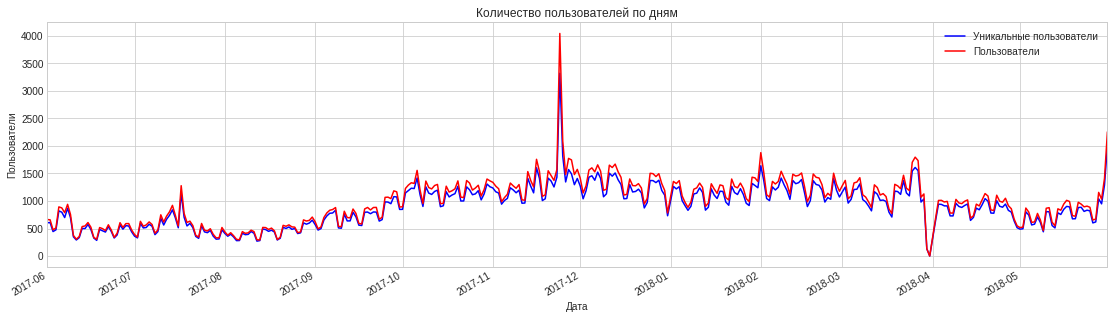

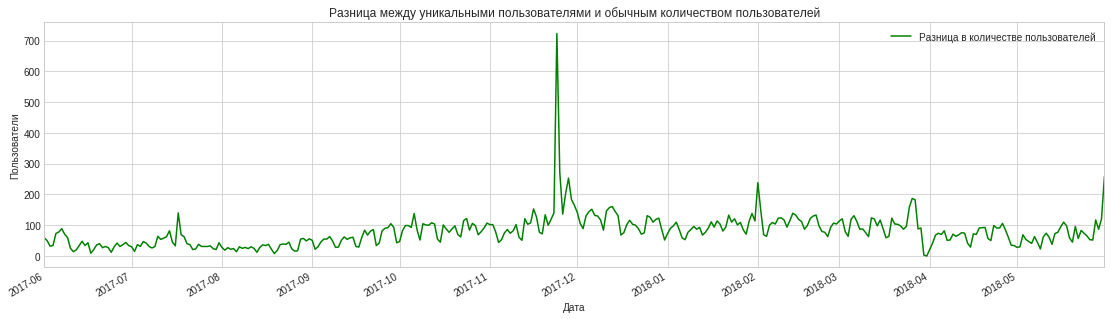

DAU: 907.00
Количество сессий в день: 987.00


In [20]:
visits.groupby('date')['uid'].nunique().plot(color='blue')
visits.groupby('date')['uid'].count().plot(figsize=(19,5),color='red')
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.legend(['Уникальные пользователи','Пользователи'])
plt.show()
(visits.groupby('date')['uid'].count()-visits.groupby('date')['uid'].nunique()).plot(figsize=(19,5),color='green')
plt.title('Разница между уникальными пользователями и обычным количеством пользователей')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.legend(['Разница в количестве пользователей'])
plt.show()
DAU = visits.groupby('date').agg({'uid': 'nunique'}).mean()
sessions=visits.groupby('date')['uid'].count().mean()
print('DAU: {0:.2f}'.format(DAU[0].astype('int')))
print('Количество сессий в день: {0:.2f}'.format(sessions.astype('int')))

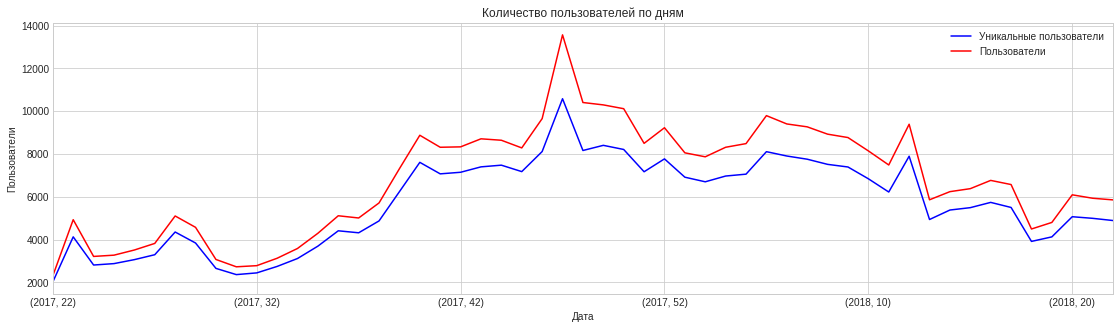

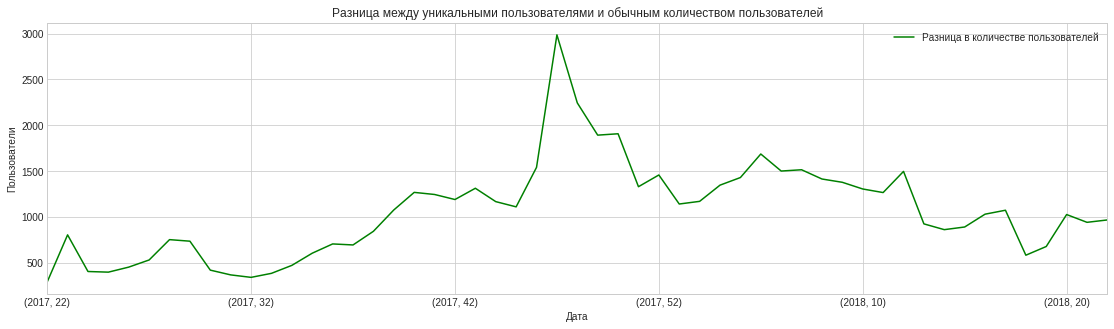

WAU: 5716.00


In [21]:
visits.groupby(['year','week_number'])['uid'].nunique().plot(color='blue')
visits.groupby(['year','week_number'])['uid'].count().plot(figsize=(19,5),color='red')
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.legend(['Уникальные пользователи','Пользователи'])
plt.show()
(visits.groupby(['year','week_number'])['uid'].count()-visits.groupby(['year','week_number'])['uid'].nunique()).plot(figsize=(19,5),color='green')
plt.title('Разница между уникальными пользователями и обычным количеством пользователей')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.legend(['Разница в количестве пользователей'])
plt.show()
WAU = visits.groupby(['year','week_number']).agg({'uid': 'nunique'}).mean()
print('WAU: {0:.2f}'.format(WAU[0].astype('int')))

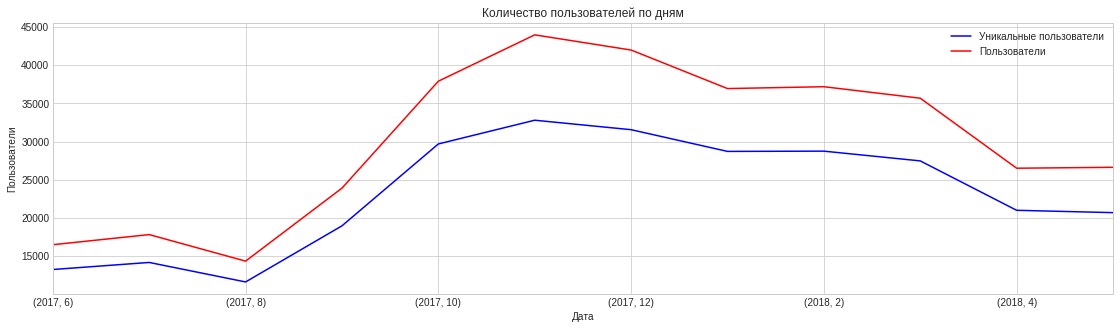

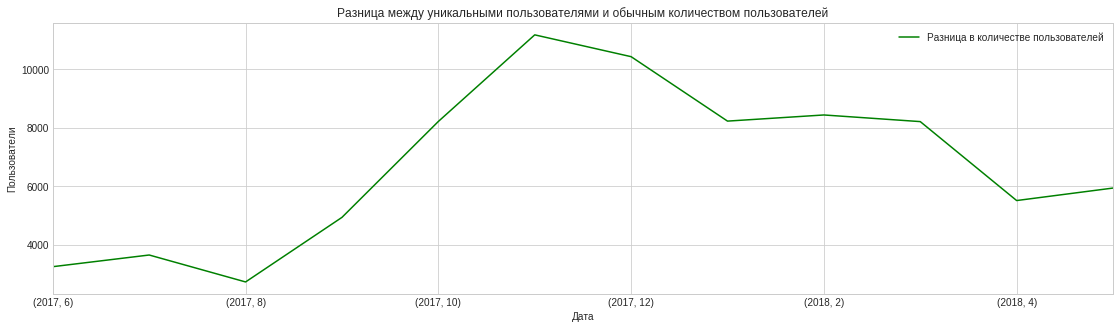

MAU: 23228.00


In [22]:
visits.groupby(['year','month'])['uid'].nunique().plot(color='blue')
visits.groupby(['year','month'])['uid'].count().plot(figsize=(19,5),color='red')
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.legend(['Уникальные пользователи','Пользователи'])
plt.show()
(visits.groupby(['year','month'])['uid'].count()-visits.groupby(['year','month'])['uid'].nunique()).plot(figsize=(19,5),color='green')
plt.title('Разница между уникальными пользователями и обычным количеством пользователей')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.legend(['Разница в количестве пользователей'])
plt.show()
MAU = visits.groupby(['year','month']).agg({'uid': 'nunique'}).mean()
print('MAU: {0:.2f}'.format(MAU[0].astype('int')))

In [23]:
sticky_mau=DAU/MAU*100
sticky_wau=DAU/WAU*100
print(sticky_wau[0])
print(sticky_mau[0])

15.88440861589881
3.908969652437603


Таким образом, среднее количество пользователей в день составляет 907, в неделю - 5716, в месяц - 23228. Среднее количество сессий в день составляет 987. 

<a id="2.1.3"></a>
#### Сколько длится одна сессия?

Для этого посчитаем, сколько обычно длится сессия в минутах. 

In [24]:
visits['session_duration_mins'] = (visits['end_ts'] - visits['start_ts']).dt.seconds/60

In [25]:
visits['session_duration_mins'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration_mins, dtype: float64

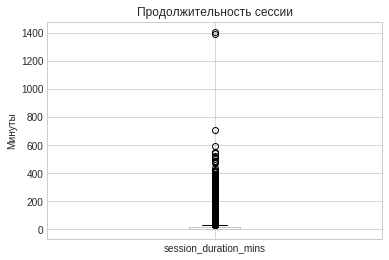

In [26]:
visits['session_duration_mins'].plot(kind='box')
plt.title('Продолжительность сессии')
plt.ylabel('Минуты')
plt.show()

Видим большое количество аномалий. Для ответа на поставленный вопрос предлагаю избавиться от них с помощью межквартального расстояния. 

In [27]:
def anomal(data,col):
    x=data[col].quantile(0.75)+1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))
    return x

Все, что больше 32, признано считать аномалией. 

In [28]:
anomal(visits,'session_duration_mins')

32.0

Посчитаем распределение количества минут на сессию. 

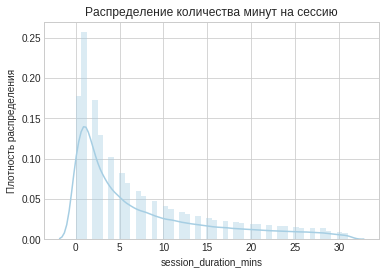

In [29]:
sns.distplot(visits[visits['session_duration_mins']<anomal(visits,'session_duration_mins')]['session_duration_mins'])
plt.title('Распределение количества минут на сессию')
plt.ylabel('Плотность распределения')
plt.show()

Распределение похоже на распределение Пуассона. Большой рост вначале с постепенным угасанием. 

In [30]:
visits[visits['session_duration_mins']<anomal(visits,'session_duration_mins')]['session_duration_mins'].describe()

count    333185.000000
mean          7.306148
std           7.786392
min           0.000000
25%           1.000000
50%           4.000000
75%          11.000000
max          31.000000
Name: session_duration_mins, dtype: float64

In [31]:
visits[visits['session_duration_mins']<anomal(visits,'session_duration_mins')]['session_duration_mins'].mode()

0    1.0
dtype: float64

Среднее время 1 сессии составляет 7 минут, медианное - 4 минуты, мода - 1 минута. 

<a id="2.1.4"></a>
#### Как часто люди возвращаются?

Для ответа на поставленный вопрос посчитаем Retention Rate по когортам. 

In [33]:
visits=visits.join(visits.groupby(['uid'])['start_ts'].min().to_frame('first_visit'),on='uid')
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [34]:
cohort_visits = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users_count = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count.columns = ['first_visit_month', 'f_uid']
initial_users_count.head()

,first_visit_month,f_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [35]:
cohort_visits=cohort_visits.join(initial_users_count.set_index('first_visit_month'),on='first_visit_month')
cohort_visits['retention']=cohort_visits['uid']/cohort_visits['f_uid']
cohort_visits.head()

,first_visit_month,lifetime,uid,f_uid,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


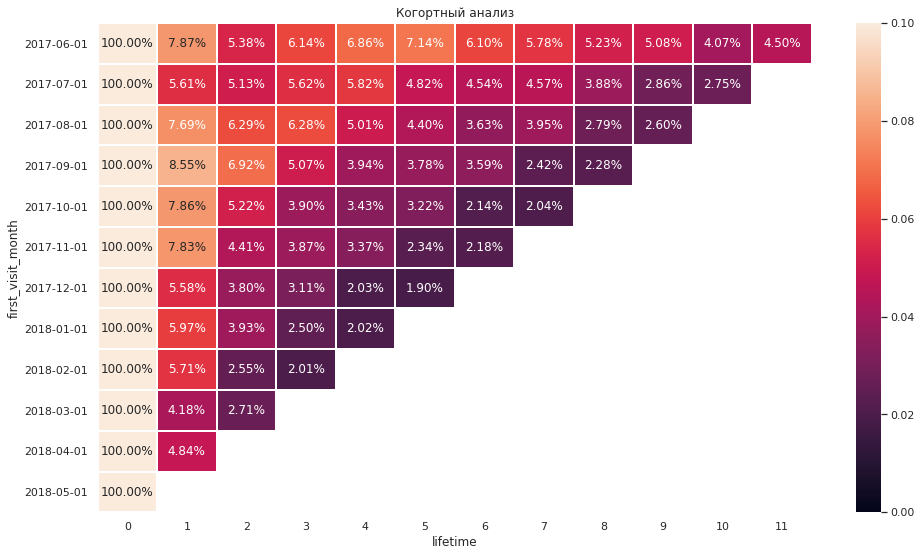

In [38]:

sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(cohort_visits.pivot_table('retention','first_visit_month','lifetime','sum'), annot=True, fmt='.2%', linewidths=1, linecolor='white',vmin=0,vmax=0.1)
ax.set_yticklabels(cohort_visits.pivot_table('retention','first_visit_month','lifetime','sum').index.date)
plt.show()


[К оглавлению](#0)

<a id="2.2"></a>
### Продажи

<a id="2.2.1"></a>
#### Когда люди начинают покупать?

Посмотрим разницу между покупкой и визитом. 

In [39]:
buying_time=visits.groupby('uid').agg({'start_ts':
                                       'min'}).rename(columns={'start_ts':
                                                               'first_visit_date'}).join(orders.groupby('uid').agg({'buy_ts':
                                                                                                                    'min'}).rename(columns={'buy_ts':
                                                                                                                                            'first_purchase_date'})).dropna()
buying_time.head()

,first_visit_date,first_purchase_date
uid,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [40]:
buying_time['buying_time'] = (buying_time['first_purchase_date'] - buying_time['first_visit_date']).dt.seconds / 60


In [41]:
buying_time.head()


,first_visit_date,first_purchase_date,buying_time
uid,,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.0
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [42]:
buying_time['buying_time'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: buying_time, dtype: float64

Присуствуют аномалии в данных. Уберем их. 

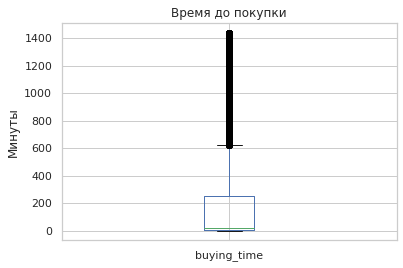

In [43]:
buying_time['buying_time'].plot(kind='box')
plt.title('Время до покупки')
plt.ylabel('Минуты')
plt.show()

In [44]:
anomal(buying_time,'buying_time')

624.0

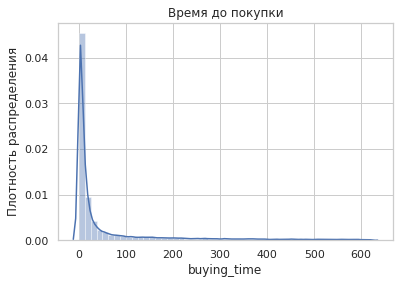

In [45]:
sns.distplot(buying_time[buying_time['buying_time']<anomal(buying_time,'buying_time')]['buying_time'])
plt.title('Время до покупки')
plt.ylabel('Плотность распределения')
plt.show()

In [46]:
buying_time[buying_time['buying_time']<anomal(buying_time,'buying_time')]['buying_time'].describe()

count    30063.000000
mean        62.186941
std        122.596704
min          0.000000
25%          3.000000
50%          9.000000
75%         43.000000
max        623.000000
Name: buying_time, dtype: float64

In [47]:
buying_time[buying_time['buying_time']<anomal(buying_time,'buying_time')]['buying_time'].mode()

0    1.0
dtype: float64

[К оглавлению](#0)

<a id="2.2.2"></a>
#### Сколько раз покупают за период?


In [48]:
orders['date'] = orders['buy_ts'].dt.date
orders['day_number'] = orders['buy_ts'].dt.day
orders['month'] = orders['buy_ts'].dt.month
orders['year'] = orders['buy_ts'].dt.year
orders['week_number'] = orders['buy_ts'].dt.week
orders['date'] = pd.to_datetime(orders['date'])

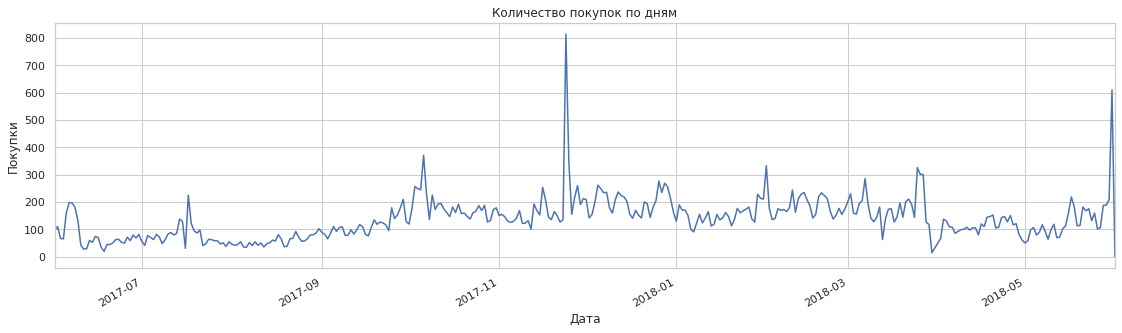

Среднее количество покупок по дням 139


In [49]:
orders.groupby(['date'])['uid'].count().plot(figsize=(19,5))
plt.title('Количество покупок по дням')
plt.xlabel('Дата')
plt.ylabel('Покупки')
plt.show()
print('Среднее количество покупок по дням {:.0f}'.format(orders.groupby(['date'])['uid'].count().mean()))

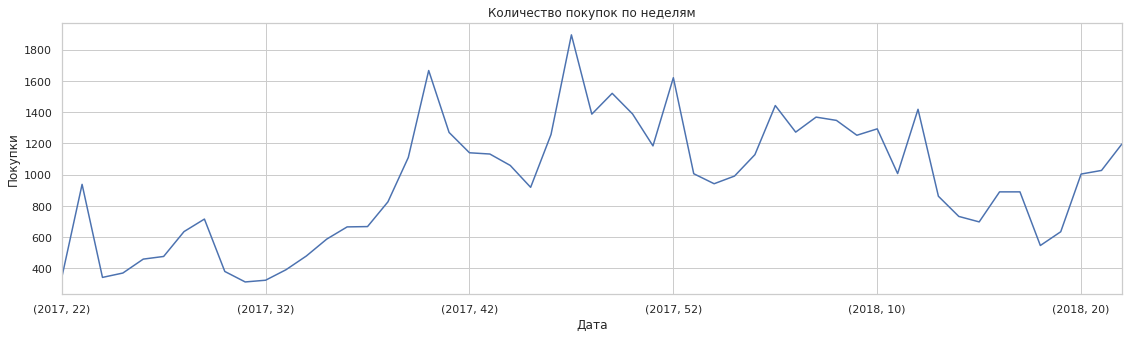

Среднее количество покупок по неделям 951


In [50]:
orders.groupby(['year','week_number'])['uid'].count().plot(figsize=(19,5))
plt.title('Количество покупок по неделям')
plt.xlabel('Дата')
plt.ylabel('Покупки')
plt.show()
print('Среднее количество покупок по неделям {:.0f}'.format(orders.groupby(['year','week_number'])['uid'].count().mean()))

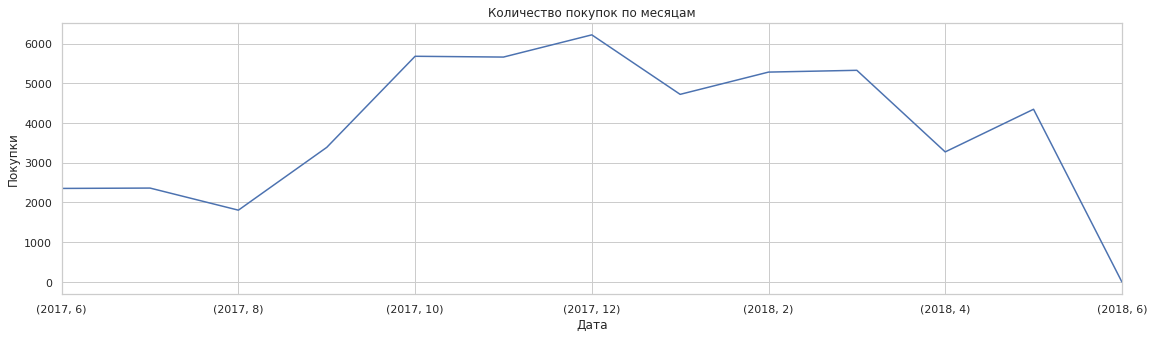

Среднее количество покупок по месяцам 3878


In [51]:
orders.groupby(['year','month'])['uid'].count().plot(figsize=(19,5))
plt.title('Количество покупок по месяцам')
plt.xlabel('Дата')
plt.ylabel('Покупки')
plt.show()
print('Среднее количество покупок по месяцам {:.0f}'.format(orders.groupby(['year','month'])['uid'].count().mean()))

Посмотрим, сколько покупок приходится на одного пользователя по когортам. 

In [52]:
orders=orders.join(orders.groupby(['uid'])['buy_ts'].min().to_frame('first_order'),on='uid')
orders['first_order']=orders['first_order'].astype('datetime64[M]')

In [53]:
orders['difference']=((orders['buy_ts']-orders['first_order'])/np.timedelta64(1, 'M')).astype('int')

In [54]:
ordersFreq=orders.groupby(['first_order','difference']).agg({'buy_ts': 'count', 'uid': 'nunique','revenue':'sum'})

In [55]:
ordersFreq['orders_per_user']=ordersFreq['buy_ts']/ordersFreq['uid']
ordersFreq['average_orders']=ordersFreq['revenue']/ordersFreq['buy_ts']

In [56]:
ordersFreq.head()

buy_ts   uid  revenue  orders_per_user  average_orders
first_order difference                                                        
2017-06-01  0             2357  2023  9567.14         1.165101        4.059033
            1              173    59   971.74         2.932203        5.616994
            2              166    50   838.58         3.320000        5.051687
            3              235    57  1978.49         4.122807        8.419106
            4              286    87  2009.91         3.287356        7.027657

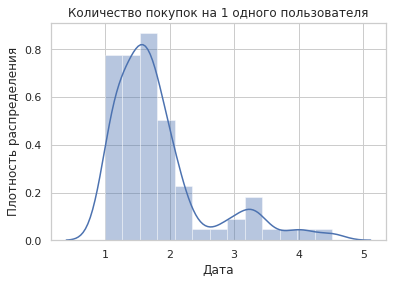

In [57]:
sns.distplot(ordersFreq['orders_per_user'])
plt.title('Количество покупок на 1 одного пользователя')
plt.xlabel('Дата')
plt.ylabel('Плотность распределения')
plt.show()

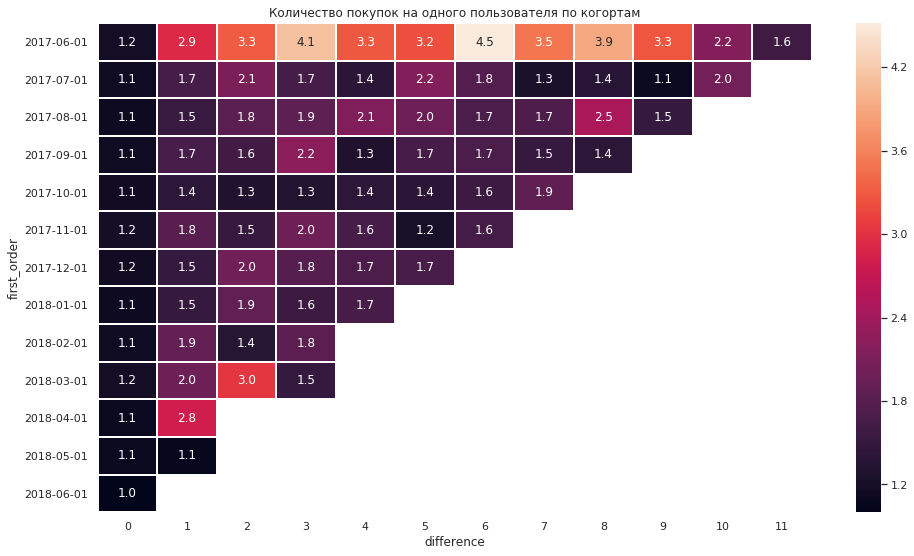

In [58]:

sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Количество покупок на одного пользователя по когортам')
ax = sns.heatmap(ordersFreq.pivot_table('orders_per_user','first_order','difference','sum'), annot=True, fmt='.2', linewidths=1, linecolor='white')
ax.set_yticklabels(ordersFreq.pivot_table('orders_per_user','first_order','difference','sum').index.date)
plt.show()


В основном на одного пользователя приходится от 1 до 2 покупок. В первый месяц 1 пользователь как правило совершает только 1 покупку, но потом из тех, кто возвращается, количество покупок на 1 пользователя начинает расти (до 2, а в январскую когорту доходило до 4.5 покупок на 1 пользователя).

<a id="2.2.3"></a>
#### Какой средний чек?

Посмотрим средний чек по когортам. 

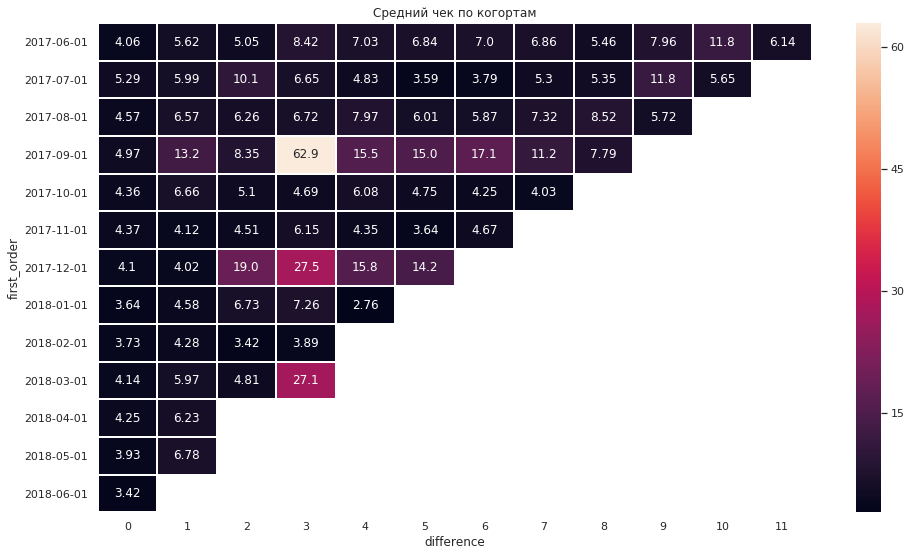

In [59]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Средний чек по когортам')
ax = sns.heatmap(ordersFreq.pivot_table('average_orders','first_order','difference','sum'), annot=True, fmt='.3', linewidths=1, linecolor='white')
ax.set_yticklabels(ordersFreq.pivot_table('average_orders','first_order','difference','sum').index.date)
plt.show()

Средний чек падает в мае/июне. Тенденция к увеличению среднего чека у пользователей, которой возвращаются. Также можно отметить когорты, в которых были совершены аномально большие продажи - это сентябрьская, декабрьская, мартовская. 

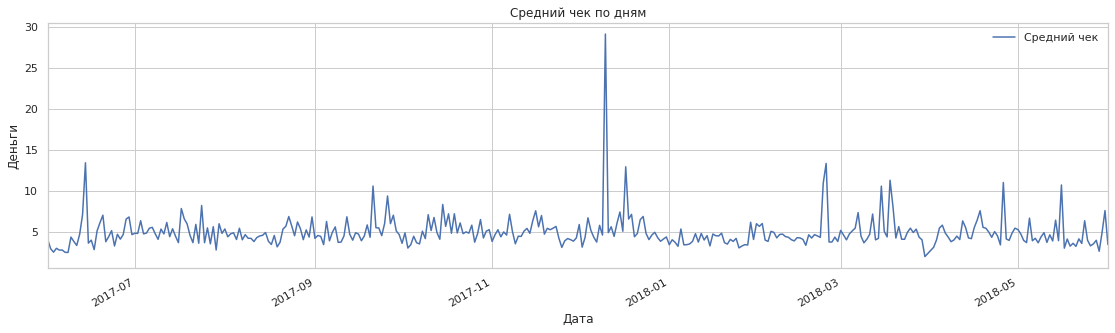

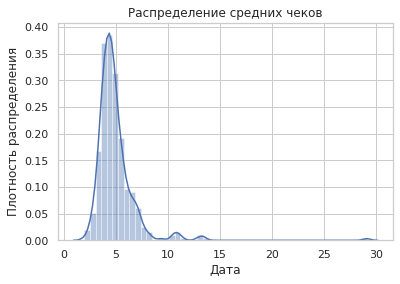

Средний чек в день 4.94


In [60]:
(orders.pivot_table('revenue','date',aggfunc='sum')/orders.pivot_table('revenue','date',aggfunc='count')).plot(figsize=(19,5))
plt.title('Средний чек по дням')
plt.xlabel('Дата')
plt.ylabel('Деньги')
plt.legend(['Средний чек'])
plt.show()
sns.distplot((orders.pivot_table('revenue','date',aggfunc='sum')/orders.pivot_table('revenue','date',aggfunc='count')))
plt.title('Распределение средних чеков')
plt.xlabel('Дата')
plt.ylabel('Плотность распределения')
plt.show()
print('Средний чек в день {0:.2f}'.format((orders.pivot_table('revenue','date',aggfunc='sum')/orders.pivot_table('revenue','date',aggfunc='count')).mean()[0]))

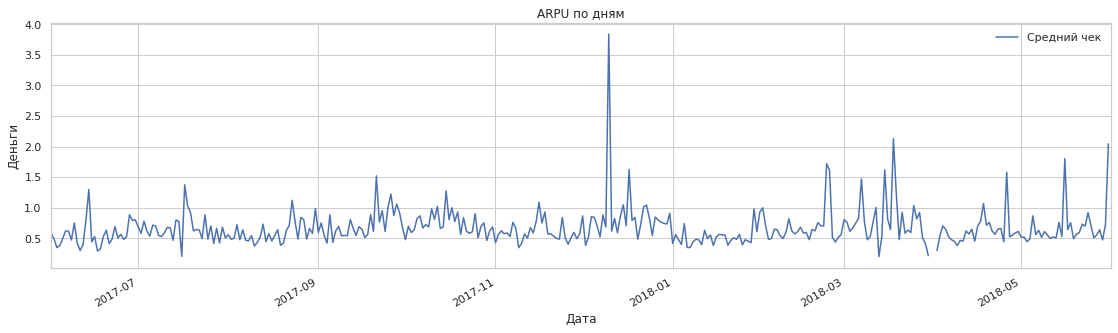

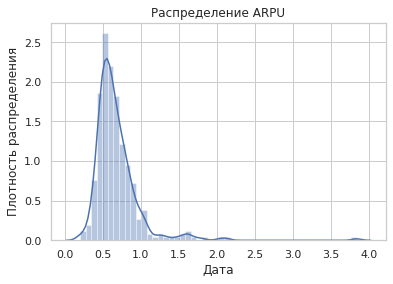

ARPU в день 0.67


In [61]:
(orders.pivot_table('revenue','date',aggfunc='sum')['revenue']/visits.groupby('date')['uid'].count()).plot(figsize=(19,5))
plt.title('ARPU по дням')
plt.xlabel('Дата')
plt.ylabel('Деньги')
plt.legend(['Средний чек'])
plt.show()
sns.distplot((orders.pivot_table('revenue','date',aggfunc='sum')['revenue']/visits.groupby('date')['uid'].count()).dropna())
plt.title('Распределение ARPU')
plt.xlabel('Дата')
plt.ylabel('Плотность распределения')
plt.show()
print('ARPU в день {0:.2f}'.format((orders.pivot_table('revenue','date',aggfunc='sum')['revenue']/visits.groupby('date')['uid'].count()).mean()))

[К оглавлению](#0)

In [75]:
# orders = orders.set_index('uid')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [90]:
costs_for_ltv = costs.rename(columns={'dt':'acquisition_date'})

In [78]:
users = visits.groupby('uid').agg({'start_ts':'min'}).rename(columns={'start_ts':'acquisition_dt'})


In [80]:
users = visits.set_index('uid').join(users)


In [82]:
users = users.query('start_ts == acquisition_dt')


In [83]:
users = users.query('start_ts == acquisition_dt')[['acquisition_dt','device','source_id']]


In [84]:
users['acquisition_date'] = users['acquisition_dt'].dt.date
users['acquisition_date'] = pd.to_datetime(users['acquisition_date'])

In [85]:
users['acquisition_month'] = users['acquisition_dt'].astype('datetime64[M]')


In [91]:
costs_for_ltv = costs_for_ltv.set_index(['source_id','acquisition_date'])


In [92]:
users = users.reset_index().set_index(['source_id','acquisition_date'])


In [93]:
users = users.join(costs_for_ltv, how='left')


In [96]:

cac = (users.reset_index().groupby(['source_id','acquisition_date']).agg({'device':'count','costs':'max'})\
      .rename(columns={'device':'users'}))


In [97]:
cac['acquisition_cost'] = cac['costs'] / cac['users']


In [98]:
users = users.join(cac[['acquisition_cost','users']], how='left').reset_index()


In [124]:
ltv = orders.join(users.set_index('uid'), how='left')[['acquisition_month','buy_month','revenue']]


In [125]:
ltv

,acquisition_month,buy_month,revenue
uid,,,
9223707061355654945,2017-10-01,2017-10-01,4.64
9224005701666002943,2017-12-01,2017-12-01,3.36
9224005701666002943,2017-12-01,2018-03-01,3.67
9225406053864431006,2017-09-01,2017-12-01,0.43
9225479525411867039,2018-02-01,2018-02-01,7.33
...,...,...,...
9221059331469344216,2017-12-01,2017-12-01,0.98
9221809908447127809,2017-12-01,2017-12-01,1.34
9222179515197516675,2018-02-01,2018-02-01,2.20


In [126]:
ltv['age_month'] = ((ltv['buy_month']-ltv['acquisition_month']) / np.timedelta64(1,'M')).round().astype('int')


revenue
first_order_month date               
2017-06-01        2017-06-01   389.46
                  2017-06-02   324.11
                  2017-06-03   166.48
                  2017-06-04   195.21
                  2017-06-05   441.49
...                               ...
2018-05-01        2018-05-28   492.56
                  2018-05-29   383.28
                  2018-05-30   693.54
                  2018-05-31  3805.78
2018-06-01        2018-06-01     3.42

[2198 rows x 1 columns]

In [127]:
ltv

,acquisition_month,buy_month,revenue,age_month
uid,,,,
9223707061355654945,2017-10-01,2017-10-01,4.64,0
9224005701666002943,2017-12-01,2017-12-01,3.36,0
9224005701666002943,2017-12-01,2018-03-01,3.67,3
9225406053864431006,2017-09-01,2017-12-01,0.43,3
9225479525411867039,2018-02-01,2018-02-01,7.33,0
...,...,...,...,...
9221059331469344216,2017-12-01,2017-12-01,0.98,0
9221809908447127809,2017-12-01,2017-12-01,1.34,0
9222179515197516675,2018-02-01,2018-02-01,2.20,0


In [123]:
ltv = ltv.groupby(['acquisition_month','age_month']).agg({'revenue':'sum'})
ltv

revenue
acquisition_month age_month          
2017-06-01        0           9557.49
                  1           2664.58
                  2           1464.69
                  3           3882.09
                  4           3940.59
...                               ...
2018-03-01        2            774.77
2018-04-01        0           8043.82
                  1           1838.73
2018-05-01        0          10368.11
                  1              3.42

[79 rows x 1 columns]

In [108]:
ltv = ltv.pivot_table(index='acquisition_month', columns='age_month', values='revenue', aggfunc='sum')


In [110]:
cohorts = (users.groupby('acquisition_month').agg({'device':'count','acquisition_cost':'sum'})
                                             .rename(columns={'device':'cohort_size'}))
cohorts

,cohort_size,acquisition_cost
acquisition_month,,
2017-06-01,13259,18015.00
2017-07-01,13140,18230.81
2017-08-01,10181,14789.17
2017-09-01,16704,24360.36
2017-10-01,25977,36322.88
2017-11-01,27248,37907.88
2017-12-01,25268,38306.03
2018-01-01,22624,33518.52
2018-02-01,22197,32707.71


In [111]:
ltv = cohorts[['cohort_size']].join(ltv)


In [112]:
ltv = ltv.div(ltv['cohort_size'], axis=0).drop(columns = ['cohort_size'])


In [114]:
ltv.cumsum(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11
acquisition_month,,,,,,,,,,,,
2017-06-01,0.720830,0.921794,1.032262,1.325051,1.622252,1.835276,2.098489,2.269755,2.444573,2.707160,2.873387,3.018783
2017-07-01,0.751514,0.832129,0.916520,0.991326,1.055785,1.116522,1.161271,1.219893,1.275032,1.320011,1.355564,NaN
2017-08-01,0.612397,0.710356,0.808710,0.901649,0.981213,1.033556,1.081355,1.203763,1.285350,1.322254,NaN,NaN
2017-09-01,0.739775,0.961307,1.087662,1.712598,1.789734,1.904081,1.961962,1.991379,2.016437,NaN,NaN,NaN
2017-10-01,0.706868,0.853530,0.904614,0.945345,0.985514,1.024864,1.047149,1.072398,NaN,NaN,NaN,NaN
2017-11-01,0.606716,0.704616,0.753898,0.804160,0.844851,0.870821,0.896459,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.667128,0.735952,0.902103,1.104882,1.162566,1.233095,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.468397,0.554664,0.606147,0.619667,0.642982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.518657,0.608059,0.637937,0.678528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="2.2.4"></a>
#### Сколько денег приносят? (LTV)

In [128]:
first_orders = orders.groupby('uid').agg({'first_order': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [129]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [130]:
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()

,uid,buy_ts,revenue,date,day_number,month,year,week_number,first_order,difference,buy_month,first_order_month
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01,1,6,2017,22,2017-06-01,0,2017-06-01,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01,1,6,2017,22,2017-06-01,0,2017-06-01,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01,1,6,2017,22,2017-06-01,0,2017-06-01,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01,1,6,2017,22,2017-06-01,0,2017-06-01,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01,1,6,2017,22,2017-06-01,0,2017-06-01,2017-06-01


In [69]:
orders_new.groupby(['first_order_month','date']).agg({'revenue': 'sum'}).sum()

revenue    252057.2
dtype: float64

In [142]:
cohorts = orders_new.groupby(['first_order_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,buy_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [143]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,buy_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Посчитаем LTV с margin_rate=1

In [145]:
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,buy_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Исправил расчет LTV

In [146]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1)[:-1]

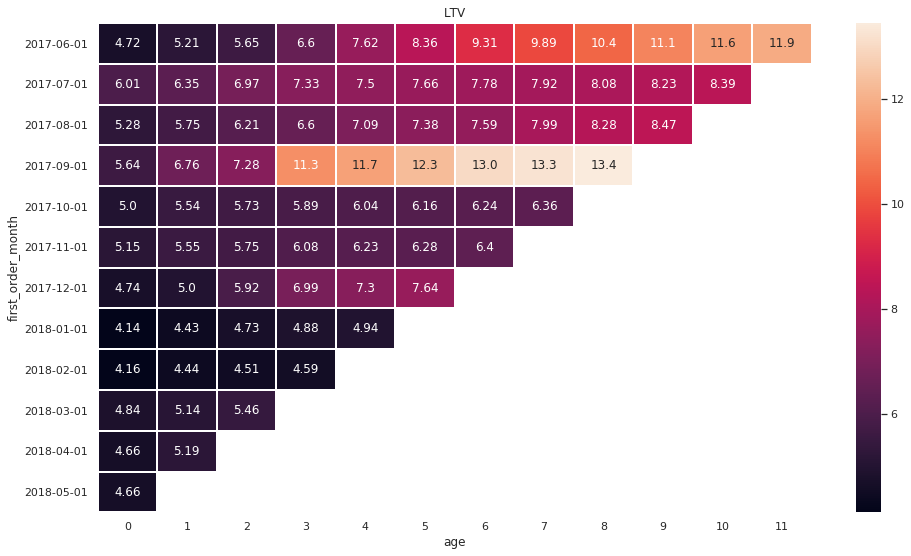

In [147]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV')
ax = sns.heatmap(output, annot=True, fmt='.3', linewidths=1, linecolor='white')
ax.set_yticklabels(output.index.date)
plt.show()

[К оглавлению](#0)

<a id="2.3"></a>
### Маркетинг

<a id="2.3.1"></a>
#### Сколько денег потратили? Всего / на каждый источник / по времени

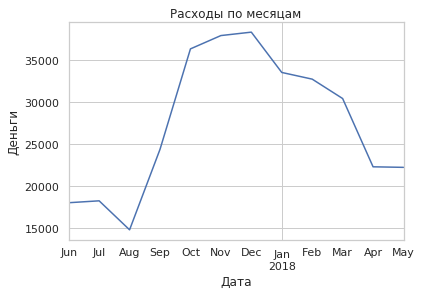

Всего денег потратили: 329131.62


In [148]:
costs.groupby('dt')['costs'].sum().groupby(pd.Grouper(freq='MS',closed='left',label='left')).sum().plot()
plt.title('Расходы по месяцам')
plt.xlabel('Дата')
plt.ylabel('Деньги')
plt.show()
print('Всего денег потратили: {0:.2f}'.format(costs.groupby('dt')['costs'].sum().groupby(pd.Grouper(freq='MS',closed='left',label='left')).sum().sum()))

In [149]:
costs['month']=costs['dt'].astype('datetime64[M]')

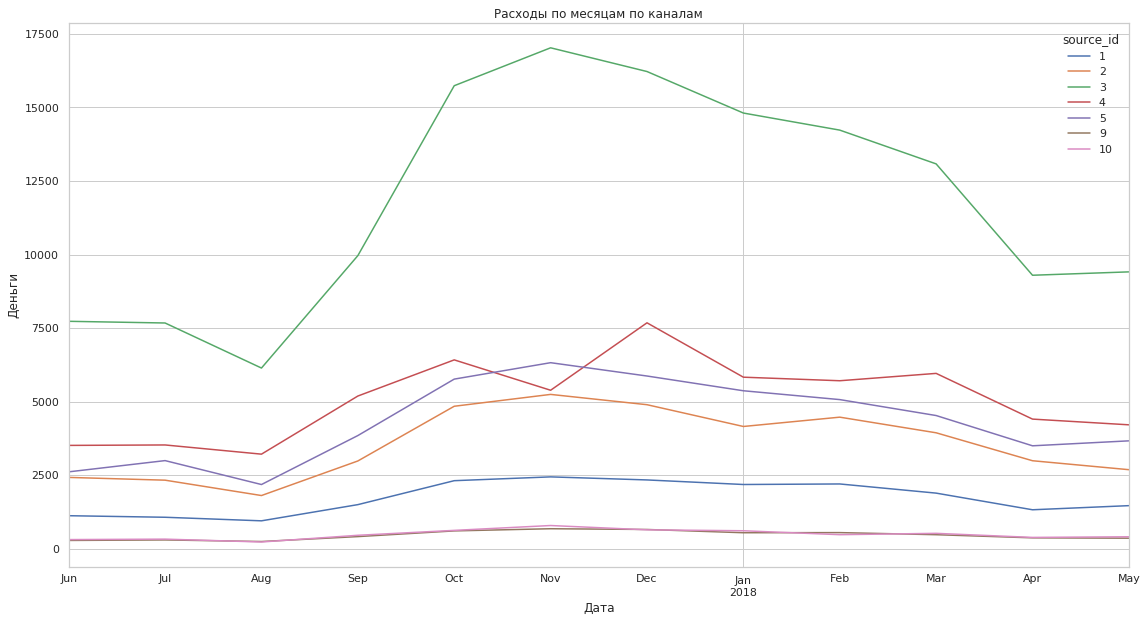

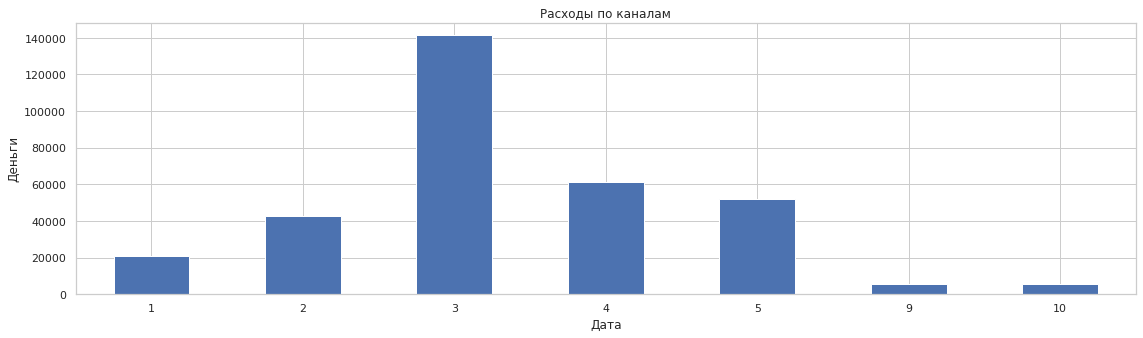

In [150]:
costs.pivot_table('costs','month','source_id','sum').plot(figsize=(19,10))
plt.title('Расходы по месяцам по каналам')
plt.xlabel('Дата')
plt.ylabel('Деньги')
plt.show()
costs.pivot_table('costs','month','source_id','sum').sum().plot(figsize=(19,5),kind='bar')
plt.title('Расходы по каналам')
plt.xlabel('Дата')
plt.ylabel('Деньги')
plt.xticks(rotation=0)
plt.show()

Всего за год расходов было на 329131.62 рубля. Больше всего расходов было на 3 канал привлечения клиентов. 

<a id="2.3.2"></a>
#### Сколько стоило привлечение одного покупателя из каждого источника?¶


In [151]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [152]:
visits_by_source = visits.query('start_ts == first_visit')
users_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'}).rename(columns={'uid':'users'})


In [153]:
cac = users_by_source.join(costs_by_source).reset_index()
cac = cac.fillna(0)

cac

,source_id,users,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,7,1,0.00
6,9,1088,5517.49
7,10,1329,5822.49


In [154]:
cac['cac'] = cac['costs'] / cac['users']
cac.sort_values('cac', ascending = False)

,source_id,users,costs,cac
2,3,10473,141321.63,13.493901
1,2,3506,42806.04,12.209367
4,5,6931,51757.10,7.467479
0,1,2899,20833.27,7.186364
3,4,10296,61073.60,5.931779
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106
5,7,1,0.00,0.000000


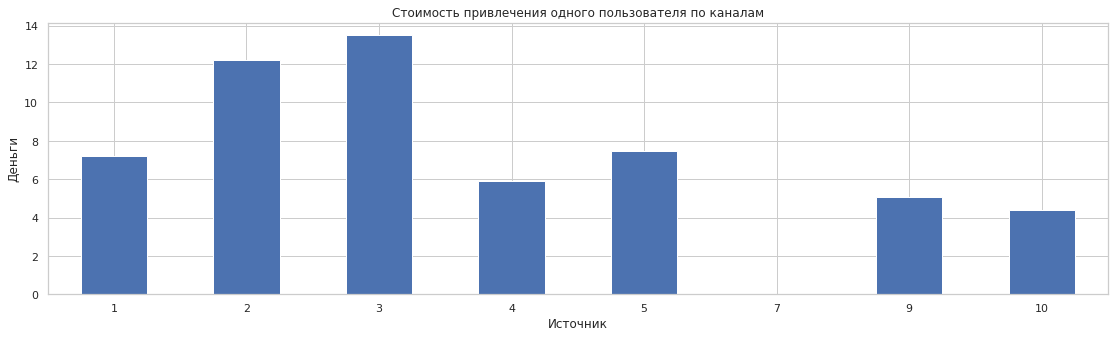

In [155]:
cac.set_index('source_id')['cac'].plot(figsize=(19,5),kind='bar')
plt.title('Стоимость привлечения одного пользователя по каналам')
plt.xlabel('Источник')
plt.ylabel('Деньги')
plt.xticks(rotation=0)
plt.show()

[К оглавлению](#0)

<a id="2.3.3"></a>
#### На сколько окупились расходы? (ROI)

In [156]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [157]:
roi = revenue_by_source.join(costs_by_source)
roi['roi'] = roi['revenue'] / roi['costs']

In [158]:
roi.sort_values('roi', ascending = False)

,revenue,costs,roi
source_id,,,
1,31090.55,20833.27,1.492351
2,46923.61,42806.04,1.096191
9,5759.40,5517.49,1.043844
5,52624.02,51757.10,1.016750
4,56696.83,61073.60,0.928336
10,4450.33,5822.49,0.764335
3,54511.24,141321.63,0.385725
7,1.22,NaN,NaN


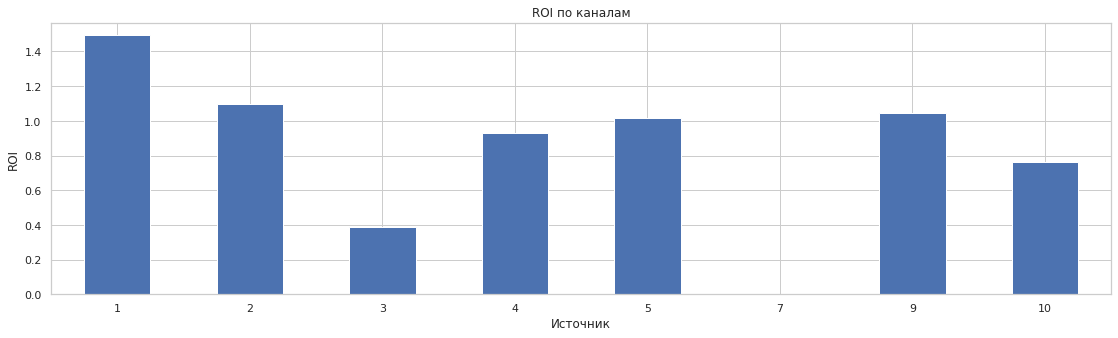

In [159]:
roi['roi'].plot(figsize=(19,5),kind='bar')
plt.title('ROI по каналам')
plt.xlabel('Источник')
plt.ylabel('ROI')
plt.xticks(rotation=0)
plt.show()

Самый большой ROI у 1 канала продвижения. 

In [160]:
orders_by_devices=(orders.merge(visits_by_source, on='uid', how='inner')).groupby(['device','source_id']).agg({'revenue':'sum'})
roi_by_devices=orders_by_devices.join(costs_by_source)
roi_by_devices['roi']=roi_by_devices['revenue']/roi_by_devices['costs']
roi_by_devices

revenue      costs       roi
device  source_id                               
desktop 1          25995.60   20833.27  1.247793
        2          40386.63   42806.04  0.943480
        3          46273.75  141321.63  0.327436
        4          43414.96   61073.60  0.710863
        5          46825.34   51757.10  0.904713
        7              1.22        NaN       NaN
        9           4866.41    5517.49  0.881997
        10          3565.86    5822.49  0.612429
touch   1           5094.95   20833.27  0.244558
        2           6536.98   42806.04  0.152712
        3           8237.49  141321.63  0.058289
        4          13281.87   61073.60  0.217473
        5           5798.68   51757.10  0.112036
        9            892.99    5517.49  0.161847
        10           884.47    5822.49  0.151906

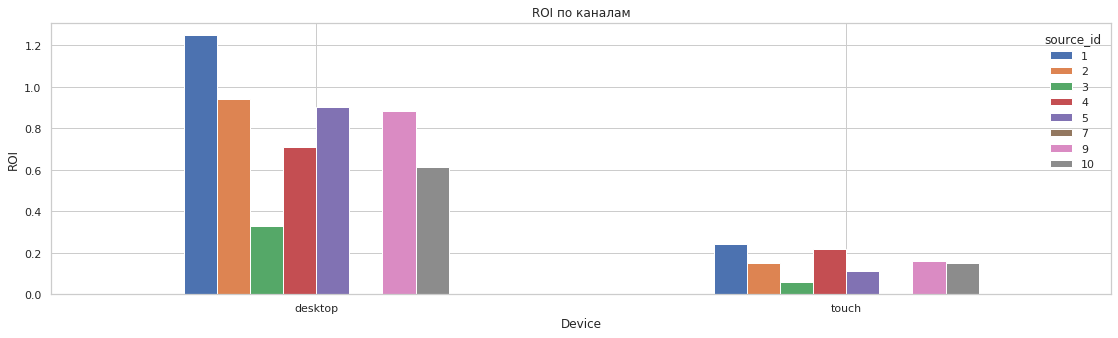

In [161]:
roi_by_devices['roi'].unstack().plot(figsize=(19,5),kind='bar')
plt.title('ROI по каналам')
plt.xlabel('Device')
plt.ylabel('ROI')
plt.xticks(rotation=0)
plt.show()

ROI c desktop намного превышает ROI с touch. 

In [162]:
monthly_roi=pd.concat([costs.groupby('month')['costs'].sum().to_frame('cost'),
           orders.groupby(by='date')['revenue'].sum().groupby(pd.Grouper(freq='MS',closed='left',label='left')).sum().to_frame('revenue')],
          axis=1)
monthly_roi['roi']=monthly_roi['revenue']/monthly_roi['cost']
monthly_roi

,cost,revenue,roi
2017-06-01,18015.00,9557.49,0.530530
2017-07-01,18240.59,12539.47,0.687449
2017-08-01,14790.54,8758.78,0.592188
2017-09-01,24368.91,18345.51,0.752824
2017-10-01,36322.88,27987.70,0.770525
2017-11-01,37907.88,27069.93,0.714098
2017-12-01,38315.35,36388.60,0.949713
2018-01-01,33518.52,19417.13,0.579296
2018-02-01,32723.03,25560.54,0.781118
2018-03-01,30415.27,28834.59,0.948030


ROI по месяцам меньше 1. Самый высокий выпал на декабрь и март.

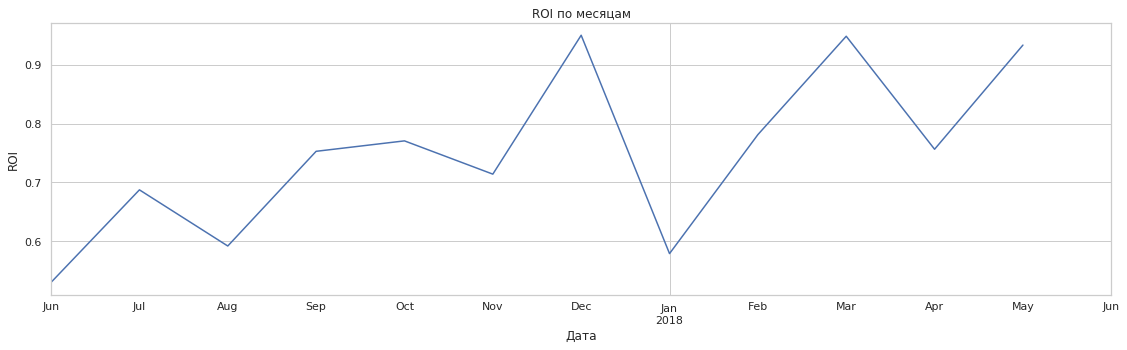

Общий ROI 0.77


In [163]:
monthly_roi['roi'].plot(figsize=(19,5))
plt.title('ROI по месяцам')
plt.xlabel('Дата')
plt.ylabel('ROI')
plt.xticks(rotation=0)
plt.show()
print('Общий ROI {:.2f}'.format(monthly_roi['revenue'].sum()/monthly_roi['cost'].sum()))

<a id="3"></a>
## Шаг 3. Вывод


Поскольку данных недостаточно (всего 1 год), то говорить о том, что присутствует сезонность невозможно. Количество пользователей почти не возвращается (возвращаемость в следующий месяц примерно 4-8%), но дальше уход происходит очень медленно. Но среди тех, кто остается, средний чек растет и количество покупок также увеличивается. Больше всего траты идут по 3 каналу, хотя по нему ROI самый маленький. Самый высокий ROI показал 1 канал, поэтому рекомендуется уменьшить траты по 3 каналу и увеличить по 1 каналу. Продажи по Desktop приносят больше прибыли. 

In [164]:
print('Код проходит полностью за', datetime.datetime.now()-starttime)

Код проходит полностью за 0:44:49.413987
